In [1]:
import json
import os
import pandas as pd
from IPython.display import display
import itertools
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import time
from pathlib import Path
import glob
import seaborn as sns
from scipy import stats
import matplotlib.patches as mpatches
import shutil
import re
#import discord

In [ ]:
apk_base = 'path/to/unpacked/apk' #Can't give you details on how to do this here (Search Engine is your friend)
dinocard_dir = 'path/to/dino/images'
output_dir = 'plots/'+player_group_description
Path(output_dir).mkdir(parents=True, exist_ok=True)

is_boost = True
player_group_description = 'Legend-epic-advantage-mai'

with open("out/conversationfile.txt", 'r') as f:
    data = f.readlines()
sent = [json.loads(m.replace('sent ->', '')) for m in filter(lambda x: x.startswith('sent'), data)]
received = [json.loads(m.strip("received <-").strip()) for m in filter(lambda x: x.startswith('received'), data)]

In [ ]:
leaderboard_file = 'out/leaderboard230.json'
leaderboard_id = int(re.findall(r'\d+', leaderboard_file)[0])
with open(leaderboard_file, "r") as f:
    leaderboard = json.load(f)
topplayers = [d['accountId'] for d in leaderboard['data']["topLeaderboardScores"]]

In [54]:
def extract_command(ms, searchcmd='j.cguap'):
    cmdms = []
    for mi in ms:
        for m in mi:
            if m['c']: #its a command
                pl = m['p']
                a = m['a'] #whatever?
                cmd = pl['c']
                cmdpl = pl['p']
                if cmd == searchcmd:
                    cmdms.append(m['p'])
    return cmdms

def parse_player_data(mdict):
    pldatas = mdict['p']['spl']
    players, dinoss, teamss = [], [], []
    for pldata in pldatas:
        dinoss.append(pd.json_normalize(pldata['cl']))
        teamss.append(pd.json_normalize(pldata['cdl']))
        pc = ['lvl', 'nxexp', 'lgt', 'id', 'title', 'exp']
        players.append(pd.DataFrame([[pldata[k] for k in pc]], columns=pc))
    return list(zip(players, dinoss, teamss))

def read_json(p):
    with open(p, 'r') as f:
        return json.load(f)

In [ ]:
#If you have no extracted apk don't execute this cell
database = read_json(os.path.join(apk_base, 'assets/Database/Assets/Data/DataDatabase.json'))
database_assets = os.path.join(apk_base, 'assets/Database')

def get_path_from_DB(dbid, databaseasset_bp=database_assets):
    try:
        return os.path.join(databaseasset_bp, database['Data'][dbid])
    except KeyError:
        print(f'id: {dbid} not in database.')
        return None

def get_dino_name_from_DB(dbid, databaseasset_bp=database_assets):
    p = get_path_from_DB(dbid, databaseasset_bp)
    if p:
        return os.path.split(p)[1][:-5]
    else:
        return 'Unknown'
    
def get_dino_rarity_from_DB(dbid, databaseasset_bp=database_assets):
    p = get_path_from_DB(dbid, databaseasset_bp)
    if p:
        with open(p, 'r') as f:
            data = json.load(f)
        rarity = data['r']['guid']
        rp = get_path_from_DB(rarity)
        if rp:
            return os.path.split(rp)[1][1:-5]

In [ ]:
rarity_colors = {'Common':'#A5ADB5',
'Rare':'#1DAAFF',
'Epic':'#FAC91C',
'Legenday':'#FF395A',
'Unique':'#08E763',
'Apex':'#374048'}

## Extract all data from log file

In [57]:
selection = topplayers[:150]
ignore_selection=False

In [58]:
dino_df = pd.DataFrame()
team_df = pd.DataFrame()
player_df = pd.DataFrame()
for pld in extract_command(received, "j.csfgpi"):
    for player, dinos, teams in parse_player_data(pld):    
        if (ignore_selection or player['id'][0] in selection) and (len(player_df) == 0 or not player['id'][0] in player_df['id'].values):
            dinos['player_id'] = player['id'][0]
            teams['player_id'] = player['id'][0]
#             dinos = dinos.set_index(['player_id', 'id'])
#             teams =  teams.set_index(['player_id', 'dsid'])
            dino_df = dino_df.append(dinos)
            team_df = team_df.append(teams)
            player_df = player_df.append(player)
print(f'Captured {len(player_df)} players data.')

Captured 150 players data.


In [ ]:
dino_df = dino_df.fillna(0)

In [ ]:
#If you have no extracted apk don't execute this cell
#map dino ids to names
name_ids = dino_df['cid'].unique()
name_dict = dict(zip(name_ids, map(lambda x: get_dino_name_from_DB(x), name_ids)))
name_dict[''] = 'Unknown'
rarity_dict = dict(zip(name_dict.values(), map(lambda x: get_dino_rarity_from_DB(x), name_ids)))#.map()
dino_df['cid']=dino_df['cid'].apply(lambda x: name_dict[x])
team_df['cl']=team_df['cl'].apply(lambda x: [name_dict[i] for i in x])

In [61]:
player_df.head(5)

,lvl,nxexp,lgt,id,title,exp
0,20,0,1536739951799,3300012056523,37,18689600
0,20,0,1527734436327,3300002597201,7,22945750
0,20,0,1531186177904,3300009493206,105,8290650
0,20,0,1536604841185,3300012022312,56,21959750
0,20,0,1531830585867,3300009909116,173,19527650


In [62]:
dino_df.head(5)

,level,crboin,dna,skn,id,cid,caeps.aepa,caeps.aeph,caeps.aeps,player_id
0,23,0,-1,,2,Velocirap,0.0,0.0,0.0,3300012056523
1,10,0,-1,,10,Apatosaur,0.0,0.0,0.0,3300012056523
2,10,0,-1,,12,Irritator2,0.0,0.0,0.0,3300012056523
3,10,0,-1,,15,Nundasuch,0.0,0.0,0.0,3300012056523
4,21,0,-1,,22,Tricerato2,0.0,0.0,0.0,3300012056523


In [63]:
player_ids = player_df['id'].unique()

In [66]:
player_ids = player_df['id'].unique()
def select_team_dino_stats(tid, did=None):
    team_level_boost_df = pd.DataFrame()
    for pid in player_ids:
        t_dino_df = dino_df[dino_df['player_id']==pid]
        if did is None:
            t_team_df = team_df[(team_df['player_id']==pid) & (team_df['dsid']==tid)]
        else:
            t_team_df = team_df[(team_df['player_id']==pid) & (team_df['dsid']==tid) & (team_df['did']==did)]
        if not (t_dino_df.empty or t_team_df.empty):
            team_level_boost_df = team_level_boost_df.append(t_dino_df[t_dino_df['cid'].isin(t_team_df['cl'].values[0])])
    return team_level_boost_df.groupby('cid').mean().round(0)
def select_team_dinos(tid, did=None):
    team_level_boost_df = pd.DataFrame()
    for pid in player_ids:
        t_dino_df = dino_df[dino_df['player_id']==pid]
        if did is None:
            t_team_df = team_df[(team_df['player_id']==pid) & (team_df['dsid']==tid)]
        else:
            t_team_df = team_df[(team_df['player_id']==pid) & (team_df['dsid']==tid) & (team_df['did']==did)]
        if not (t_dino_df.empty or t_team_df.empty):
            team_level_boost_df = team_level_boost_df.append(t_dino_df[t_dino_df['cid'].isin(t_team_df['cl'].values[0])])
    return team_level_boost_df.sort_values(by='cid')

def mark_team_dinos(tid):
    dinos = pd.DataFrame()
    for pid in player_ids:
        t_dino_df = dino_df[dino_df['player_id']==pid].copy()
        t_team_df = team_df[(team_df['player_id']==pid) & (team_df['dsid']==tid)]
        if not (t_dino_df.empty or t_team_df.empty):
            t_dino_df['team'] = t_dino_df['cid'].isin(t_team_df['cl'].values[0])
            dinos = dinos.append(t_dino_df)
    return dinos.sort_values(by='cid')

## Tournament Events

In [74]:
tournament_ids = [] #list(team_df.loc[(team_df['did'] == "TOURNAMENT")]['dsid'].unique()) if len(team_df)>0 else []
tournament_id_description = {}
leaderboardid_tid = {}
today = time.time()
p_t = lambda x: datetime.utcfromtimestamp(x).strftime('%d.%m-%H:%M')
for i, evt_data in enumerate(extract_command(received, "x.ef")):
    for evt in sorted(evt_data['p']['e'], key=lambda x: x['as']+x['d']['sdt'] if 'd' in x and 'sdt' in x['d'] else -1):
        tournament_id_description[evt['i']] = evt['p']
        if evt['n'] == 'TournamentEvent':
            startdelta = evt['d']['sdt']*60*60
            enddelta = evt['d']['edt']*60*60
            startdate = evt['as']/1000+startdelta
            enddate = evt['as']/1000+enddelta
            if evt['d']['type'] == 'evt' and (startdate <= today) and (today <= enddate):
                print('current tournament:')
            print(f"Found Tournament: {p_t(int(startdate))} to {p_t(enddate)} -- {evt['p']} -- {evt['i']} -- {evt['d']['cli']}\n")
            leaderboardid_tid[evt['d']['cli']] = evt['i']

Found Tournament: 06.04-15:00 to 04.05-15:00 -- 2022-04 Season - Bumpy -- CPG_YMHWKLFC6DAZ5RDR/SKBU4X0G9RR1I4PR/EVT_LVGLA2PL0QLLMHA6 -- 222

Found Tournament: 08.04-15:00 to 11.04-15:00 -- Champ CRELU All CRL BLT Skill Coin -- CPG_WQVAZLC2WVEA94BG/SJK9BFPHRMS0Z156/EVT_LVGLA2PL0QLLMHA6 -- 224

Found Tournament: 15.04-15:00 to 18.04-15:00 -- Champ CRELU All Adv CRL BLT Diplocaulus2 -- CPG_O46KPU7ZEDTJFYL4/GVRAG414F0EUFXD3/EVT_LVGLA2PL0QLLMHA6 -- 225

Found Tournament: 22.04-15:00 to 25.04-15:00 -- Champ RE All Adv CRL Compsognathus -- CPG_08NRWK4Q7SOZUCOP/8CLHKO5WE8D0XJYI/EVT_LVGLA2PL0QLLMHA6 -- 226

Found Tournament: 29.04-15:00 to 02.05-15:00 -- Champ RE All Skill CRL AEP -- CPG_5WCSYQBXSLG6H9GJ/IP06XO6N7V0PJ5CV/EVT_LVGLA2PL0QLLMHA6 -- 227

Found Tournament: 04.05-15:00 to 01.06-15:00 -- 2022-05 Season - Ailurarctos -- CPG_QMNDCATEK6SYOEEF/NA4JNFM4DW8FTB24/EVT_LVGLA2PL0QLLMHA6 -- 228

current tournament:
{'p': 'Champ CR All Skill Coin', 'r': 5, 'as': 1651676400000, 's': 1651676400000, 

Tournament: CPG_HU0V3OIJULP8YHMF/7W741Q5XQD9S2SPT/EVT_LVGLA2PL0QLLMHA6


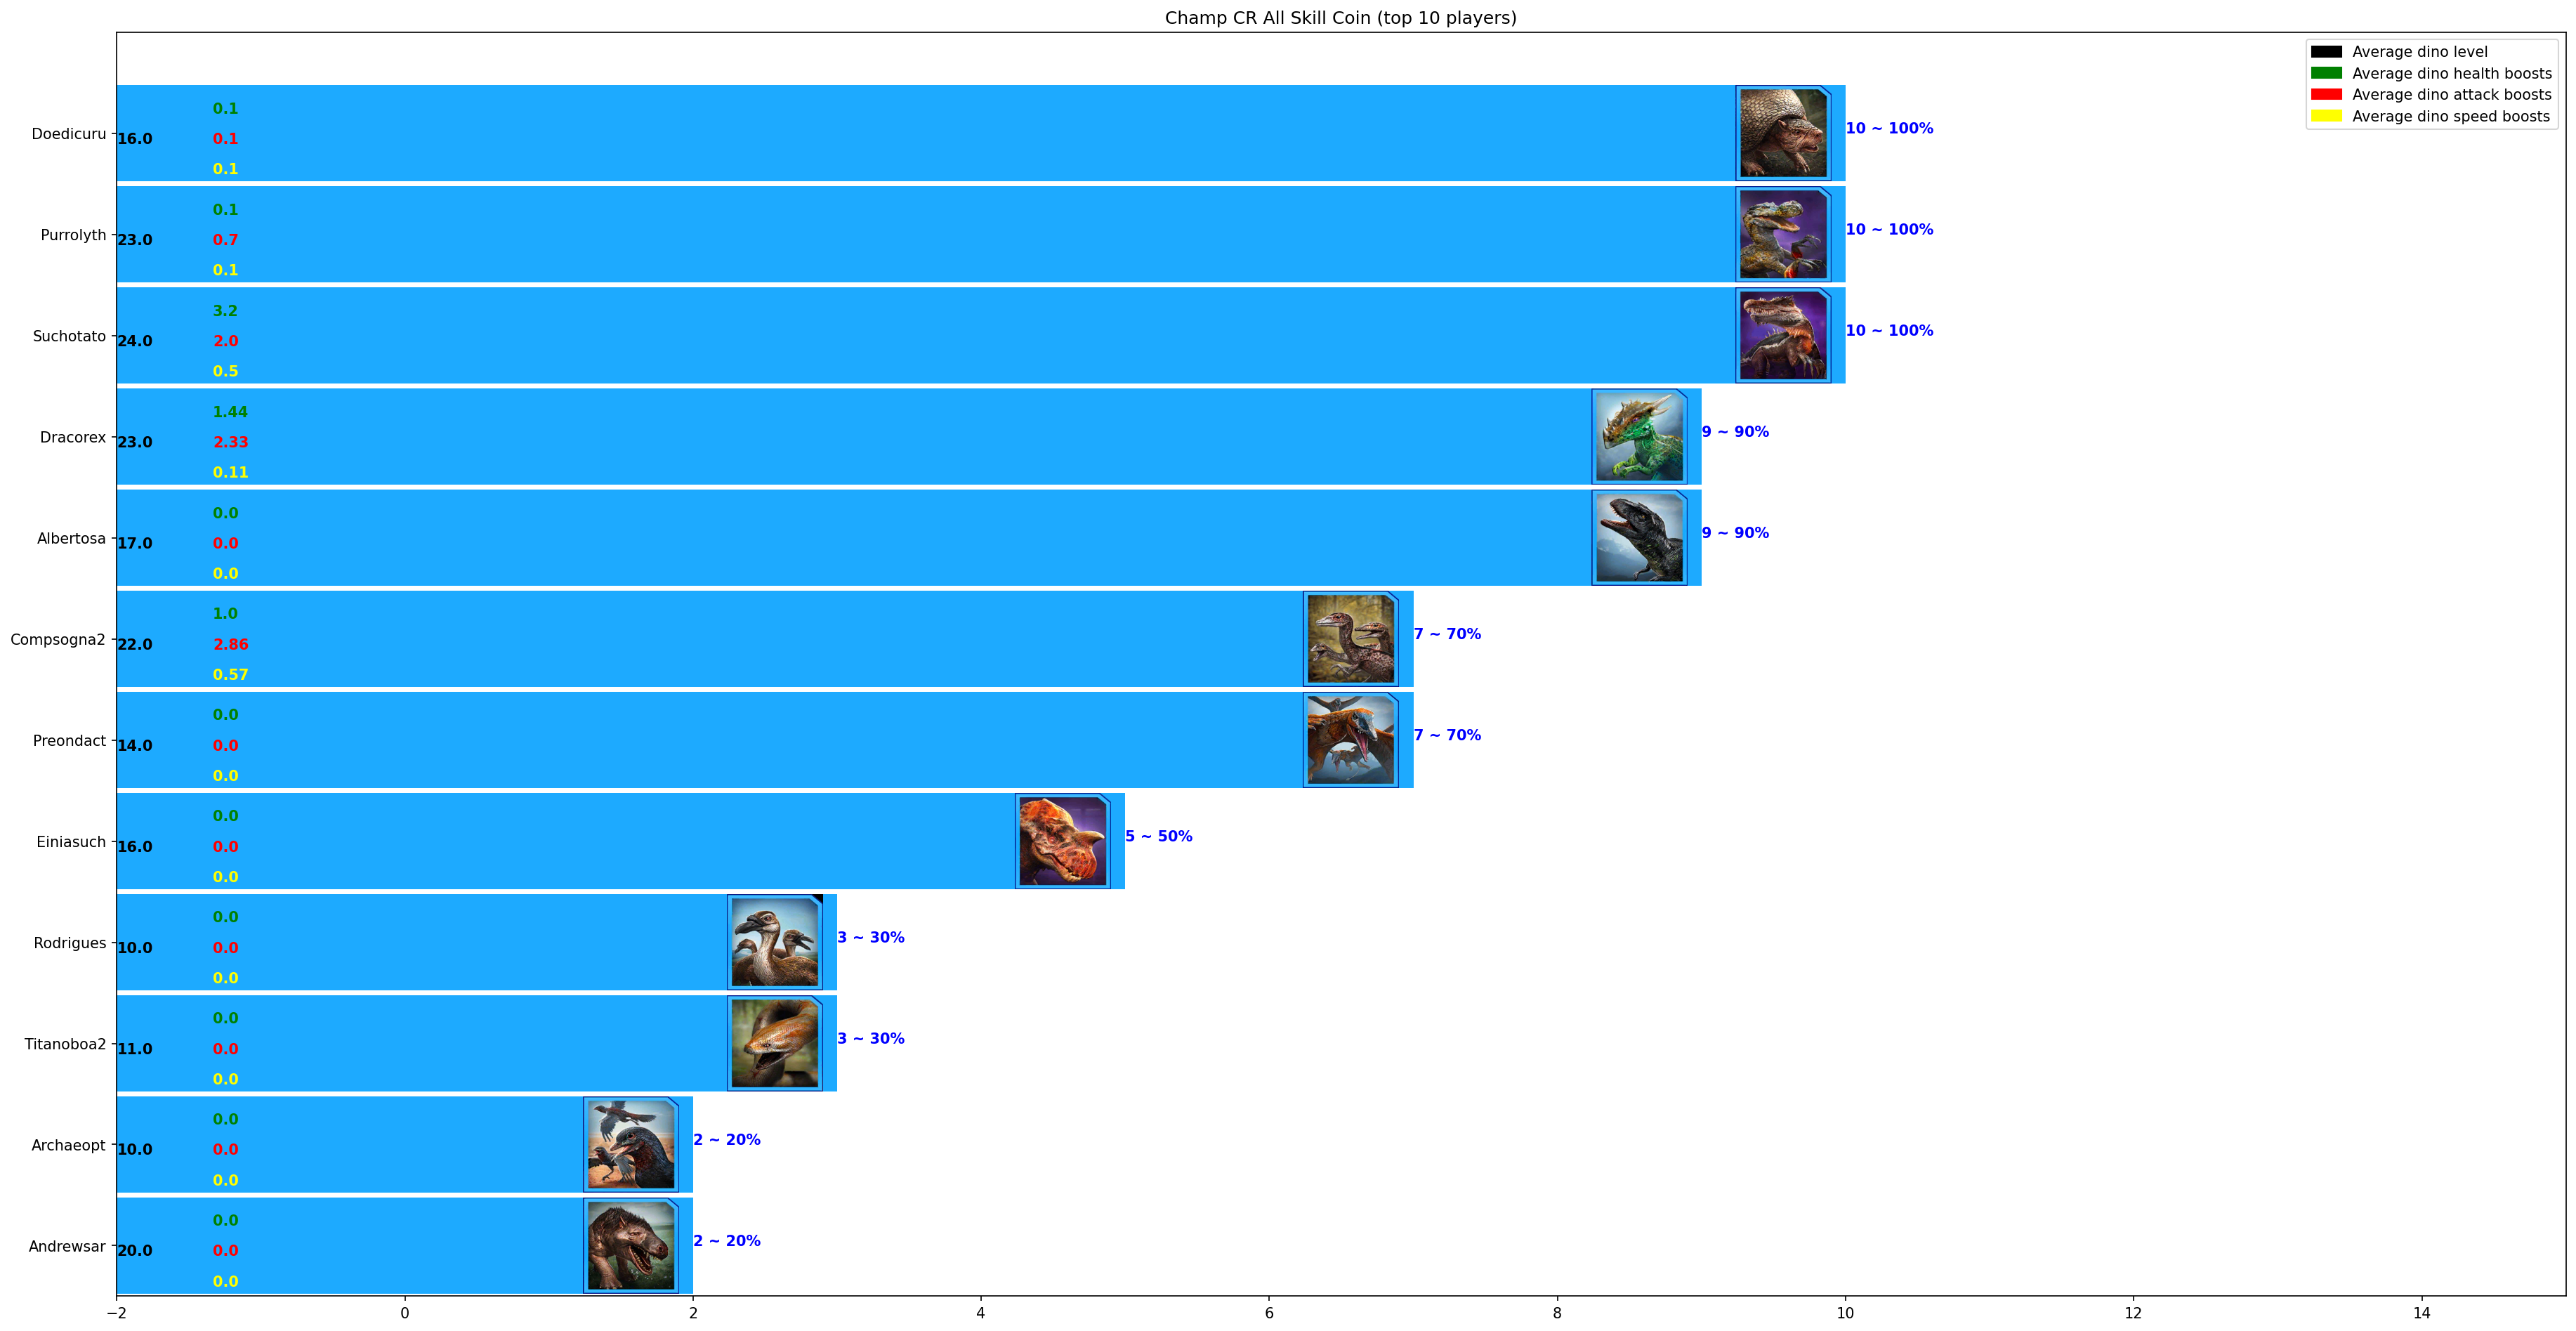

In [49]:
#If you have no extracted apk you have to make adjustments
tid = leaderboardid_tid[leaderboard_id]
name = tid
group = team_df.loc[(team_df['did'] == "TOURNAMENT") & (team_df['dsid'] == tid)]
if is_boost:
    dino_stats = select_team_dino_stats(tid)
real_name = tournament_id_description[tid]
print(f"Tournament: {tid}")
dino_counts = list(Counter(itertools.chain.from_iterable(group['cl'])).items())
dino_counts = list(filter(lambda x: int(x[1]/len(group)*100)>0 and x[1]>1, dino_counts))
dino, count = zip(*sorted(dino_counts, key=lambda x: x[1]))
#plt.style.use('seaborn')
fig = plt.figure(figsize=(30,20), dpi=150)
#plt.figure()
plt.title(real_name + f" (top {len(group)} players)")
width =  (max(count)-min(count))/len(dino)
stat_width = width*2
height = 0.95
plt.xlim(-width-stat_width, max(count)+5)
plt.ylim(-0.5, len(count))
colors = [rarity_colors[rarity_dict[d]] for d in dino]
plt.barh(y=dino, width=[c+width+stat_width for c in count], height=height, left=-(width+stat_width), color=colors, align='center', zorder=1)
for i in range(len(count)):
    v = count[i]
    dn = dino[i]
    plt.text(v , i, f"{v} ~ {int(v/len(group)*100)}%", color='blue', fontweight='bold')
    if is_boost:
        stat_row = dino_stats[dino_stats.index==dn]
        plt.text(-width-stat_width , i-0.1, f"{stat_row['level'].values[0]}", color='black', fontweight='bold')
        plt.text(-width-stat_width/2 , i-0.1-0.3, f"{stat_row['caeps.aeps'].values[0]/100}", color='yellow', fontweight='bold')
        plt.text(-width-stat_width/2, i-0.1, f"{stat_row['caeps.aepa'].values[0]/100}", color='red', fontweight='bold')
        plt.text(-width-stat_width/2 , i-0.1+0.3, f"{stat_row['caeps.aeph'].values[0]/100}", color='green', fontweight='bold')

    imgpath = glob.glob(os.path.join(dinocard_dir, f'*{dn}*.png'))
    if imgpath != []:
        img = plt.imread(imgpath[0])
        plt.imshow(img, extent=[v-width-0.1, v-0.1, i-height/2, i+height/2], zorder=2, aspect=width/height)
if is_boost:
    black = mpatches.Patch(color='black', label='Average dino level')
    green = mpatches.Patch(color='green', label='Average dino health boosts')
    red = mpatches.Patch(color='red', label='Average dino attack boosts')
    yellow = mpatches.Patch(color='yellow', label='Average dino speed boosts')
    plt.legend(handles=[black, green, red, yellow])
plt.savefig(os.path.join(output_dir, f"Tournament:{real_name}-Top{len(group)}.jpg"), transparent=False, dpi=fig.dpi, bbox_inches='tight')
plt.show()

# Tournament Teams

PVECHALLENGE: CPG_6DZOZIQOQ1AGPR5A/NZ4KV4RU7XGN0W4A/EVT_LVGLA2PL0QLLMHA6


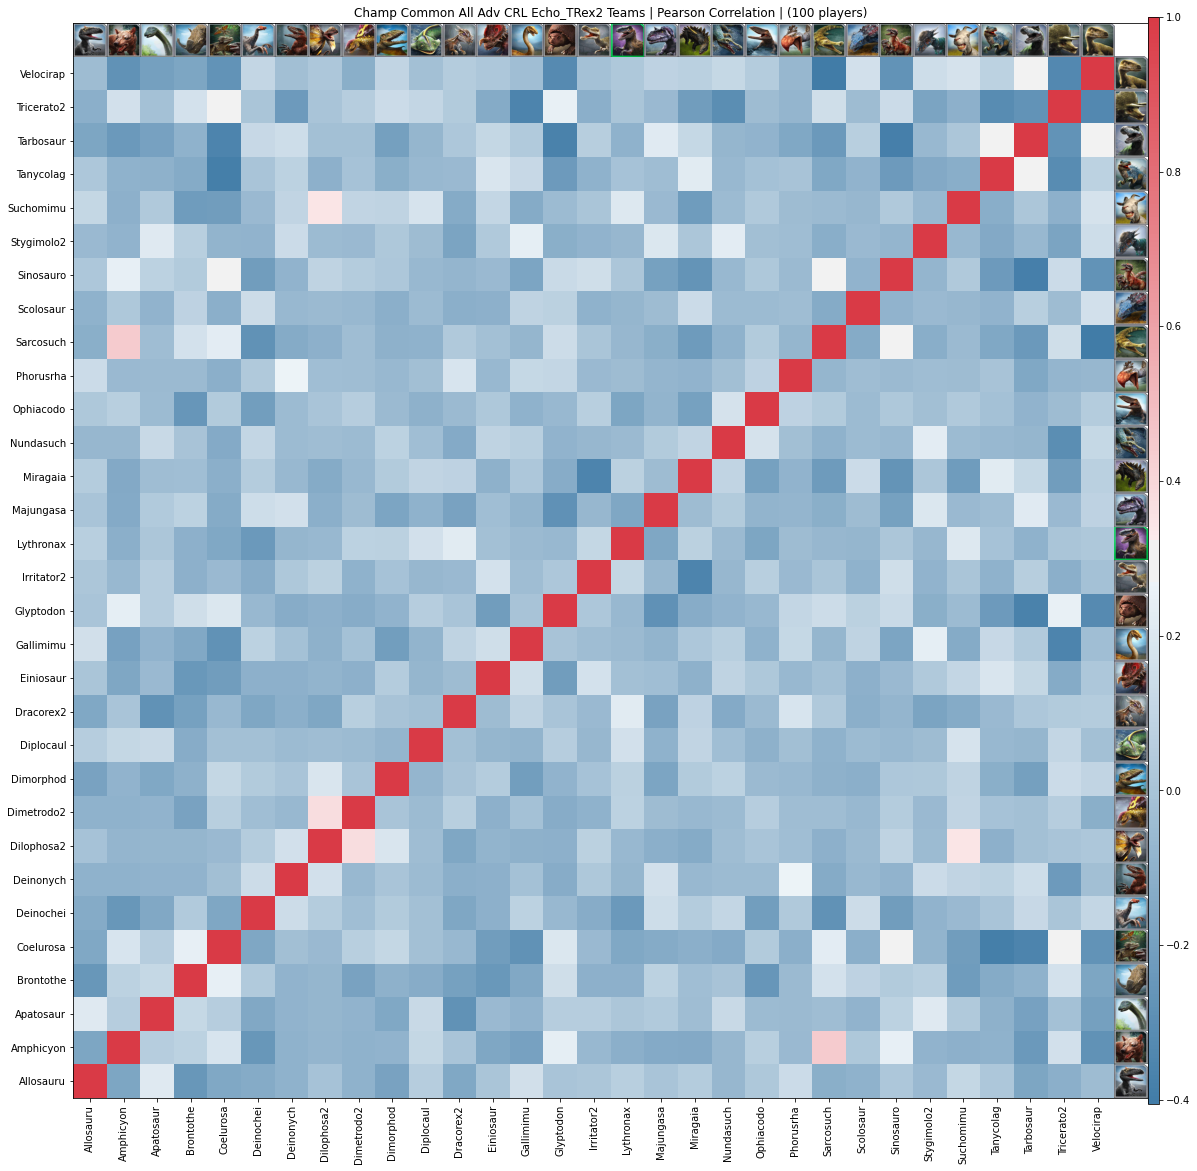

In [26]:
tid = leaderboardid_tid[leaderboard_id]
name = tid
group = team_df.loc[(team_df['did'] == "TOURNAMENT") & (team_df['dsid'] == tid)]
print(f"{team_df['did'].values[0]}: {tid}")
real_name = tournament_id_description[name]
unique_dinos = Counter(itertools.chain.from_iterable(group['cl']))
unique_dinos = sorted([d[0] for d in unique_dinos.items() if d[1]>1])
N = len(unique_dinos)
teams = []
for team in group['cl'].to_list():
    teams.append(np.array([1 if d in team else 0 for d in unique_dinos]))
teams = np.stack(teams).T
plt.figure(figsize=(20, 20))
height = 1
plt.xlim(-0.5, N-0.5+height)
plt.ylim(-0.5, N-0.5+height)
plt.title(real_name + f" Teams | Pearson Correlation | ({len(group)} players)")
cmap = sns.diverging_palette(240, 10, as_cmap=True)
cmap.set_bad('white' ,1.)
coeff = plt.imshow(np.corrcoef(teams), cmap=cmap, zorder=1)
plt.xticks(range(len(unique_dinos)), unique_dinos, rotation='vertical')
plt.yticks(range(len(unique_dinos)), unique_dinos)
for i in range(len(unique_dinos)):
    dn = unique_dinos[i]
    imgpath = glob.glob(os.path.join(dinocard_dir, f'*{dn}*.png'))
    if imgpath == []:
        imgpath = glob.glob(os.path.join(dinocard_dir, '*Goat.png'))
    img = plt.imread(imgpath[0])    
    l = len(unique_dinos)
    plt.imshow(img, extent=[i-height/2, i+height/2, l-height/2, l+height/2], zorder=2)
    plt.imshow(img, extent=[l-height/2, l+height/2, i-height/2, i+height/2], zorder=2)

plt.colorbar(coeff, fraction=0.037, pad=0.00, aspect=100)
plt.savefig(os.path.join(output_dir, f'Dinoteam-pearson-{real_name}.jpg'), bbox_inches='tight')
plt.show()

## Arena Teams

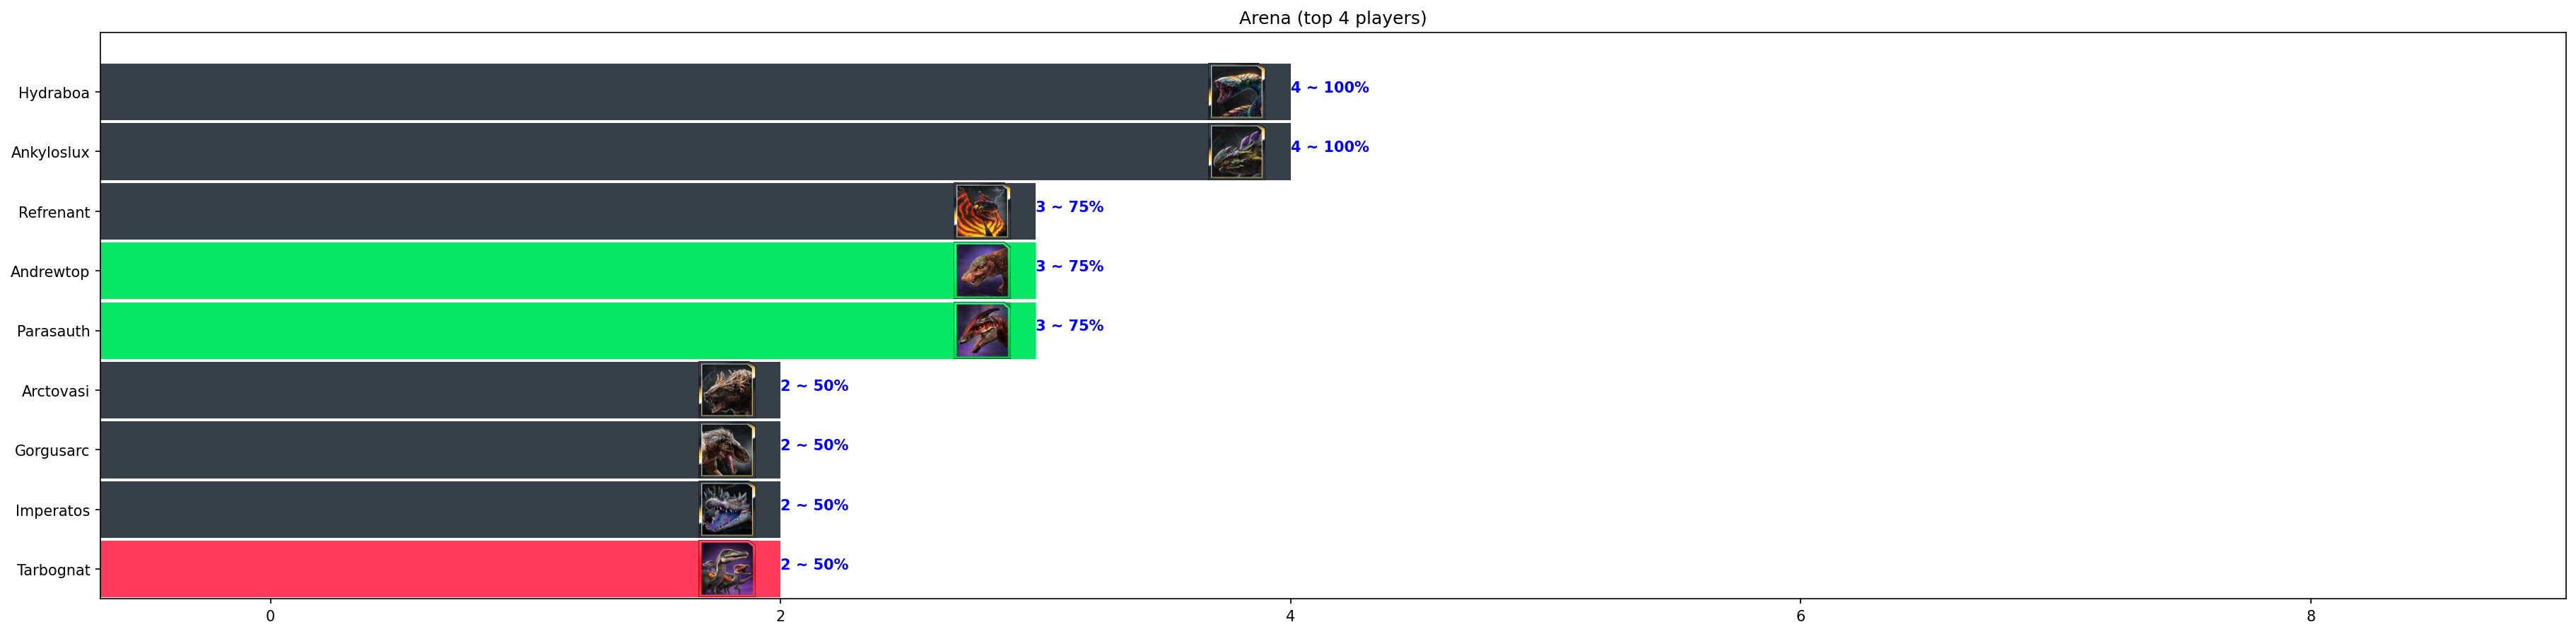

In [68]:
group = team_df.loc[(team_df['dsid'] == "MainDeck") & (team_df['did'] == "PVP")]
if is_boost:
    dino_stats = select_team_dino_stats("MainDeck", 'PVP')
real_name = "Arena"#tournament_id_description[tid]
dino_counts = list(Counter(itertools.chain.from_iterable(group['cl'])).items())
dino_counts = list(filter(lambda x: int(x[1]/len(group)*100)>0 and x[1]>1, dino_counts))
dino, count = zip(*sorted(dino_counts, key=lambda x: x[1]))
#plt.style.use('seaborn')
fig = plt.figure(figsize=(30,20), dpi=150)
#plt.figure()
plt.title(real_name + f" (top {len(group)} players)")
width =  (max(count)-min(count))/len(dino)
stat_width = width*2
height = 0.95
plt.xlim(-width-stat_width, max(count)+5)
plt.ylim(-0.5, len(count))
colors = [rarity_colors[rarity_dict[d]] for d in dino]
plt.barh(y=dino, width=[c+width+stat_width for c in count], height=height, left=-(width+stat_width), color=colors, align='center', zorder=1)
for i in range(len(count)):
    v = count[i]
    dn = dino[i]
    plt.text(v , i, f"{v} ~ {int(v/len(group)*100)}%", color='blue', fontweight='bold')
    if is_boost:
        stat_row = dino_stats[dino_stats.index==dn]
        plt.text(-width-stat_width , i-0.1, f"{stat_row['level'].values[0]}", color='black', fontweight='bold')
        plt.text(-width-stat_width/2 , i-0.1-0.3, f"{stat_row['caeps.aeps'].values[0]/100}", color='yellow', fontweight='bold')
        plt.text(-width-stat_width/2, i-0.1, f"{stat_row['caeps.aepa'].values[0]/100}", color='red', fontweight='bold')
        plt.text(-width-stat_width/2 , i-0.1+0.3, f"{stat_row['caeps.aeph'].values[0]/100}", color='green', fontweight='bold')

    imgpath = glob.glob(os.path.join(dinocard_dir, f'*{dn}*.png'))
    if imgpath != []:
        img = plt.imread(imgpath[0])
        plt.imshow(img, extent=[v-width-0.1, v-0.1, i-height/2, i+height/2], zorder=2, aspect=width/height)
if is_boost:
    black = mpatches.Patch(color='black', label='Average dino level')
    green = mpatches.Patch(color='green', label='Average dino health boosts')
    red = mpatches.Patch(color='red', label='Average dino attack boosts')
    yellow = mpatches.Patch(color='yellow', label='Average dino speed boosts')
    plt.legend(handles=[black, green, red, yellow])
plt.savefig(os.path.join(output_dir, f"Arena-top{len(group)}.jpg"), transparent=False, dpi=fig.dpi, bbox_inches='tight')
plt.show()

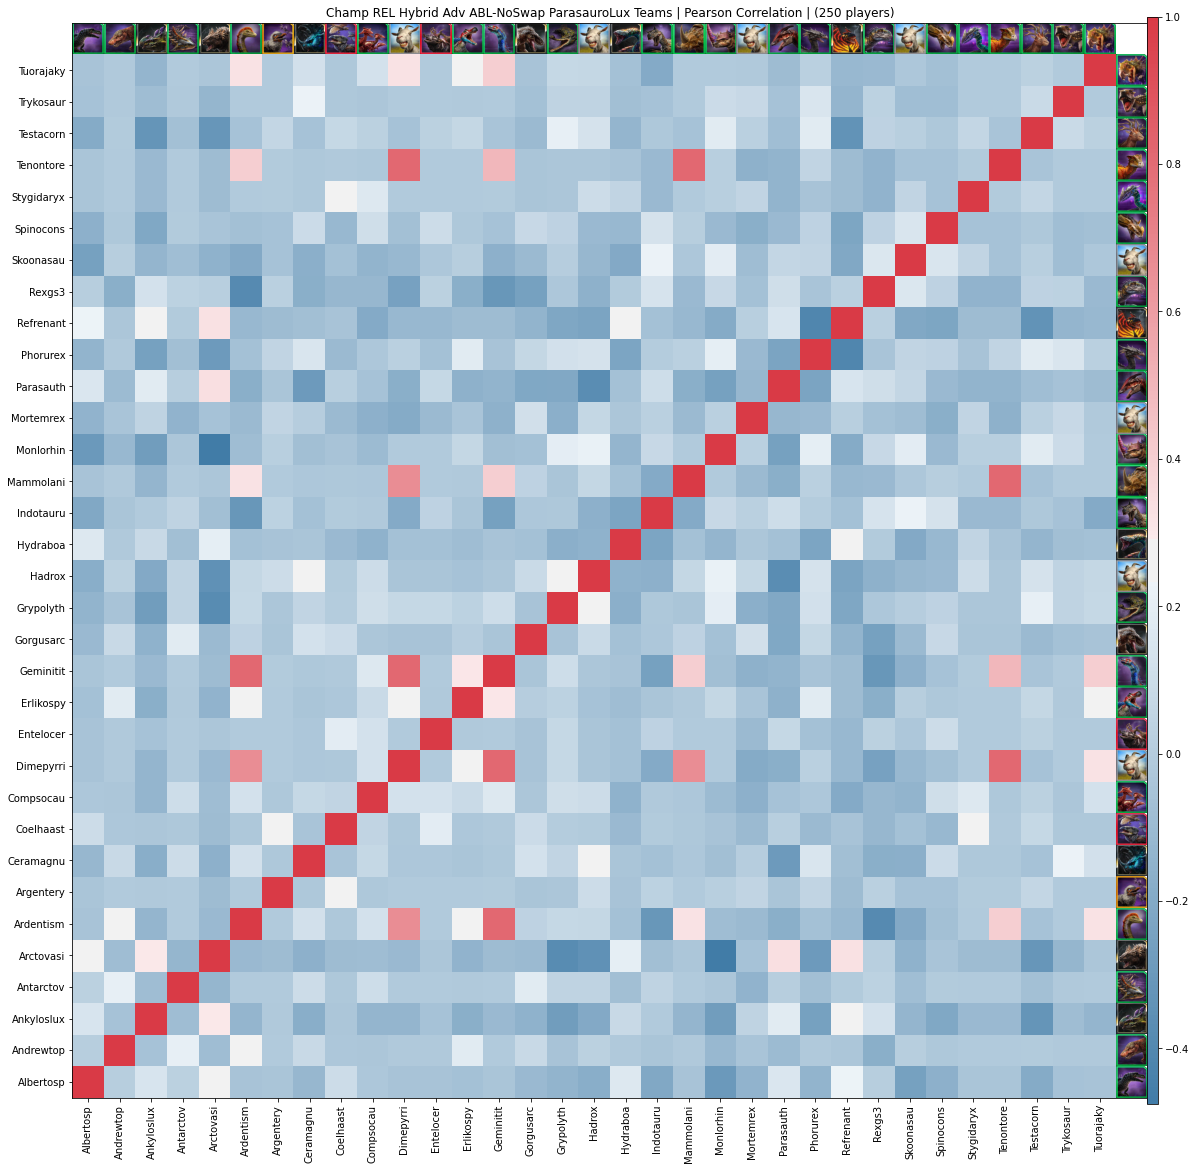

In [107]:
name = "Arena"
group = team_df.loc[(team_df['dsid'] == "MainDeck") & (team_df['did'] == "PVP")]
unique_dinos = Counter(itertools.chain.from_iterable(group['cl']))
unique_dinos = sorted([d[0] for d in unique_dinos.items() if d[1]>1])
N = len(unique_dinos)
teams = []
for team in group['cl'].to_list():
    teams.append(np.array([1 if d in team else 0 for d in unique_dinos]))
teams = np.stack(teams).T
plt.figure(figsize=(20, 20))
height = 1
plt.xlim(-0.5, N-0.5+height)
plt.ylim(-0.5, N-0.5+height)
plt.title(real_name + f" Teams | Pearson Correlation | ({len(group)} players)")
cmap = sns.diverging_palette(240, 10, as_cmap=True)
cmap.set_bad('white' ,1.)
coeff = plt.imshow(np.corrcoef(teams), cmap=cmap, zorder=1)
plt.xticks(range(len(unique_dinos)), unique_dinos, rotation='vertical')
plt.yticks(range(len(unique_dinos)), unique_dinos)
for i in range(len(unique_dinos)):
    dn = unique_dinos[i]
    imgpath = glob.glob(os.path.join(dinocard_dir, f'*{dn}*.png'))
    if imgpath == []:
        imgpath = glob.glob(os.path.join(dinocard_dir, '*Goat.png'))
    img = plt.imread(imgpath[0])    
    l = len(unique_dinos)
    plt.imshow(img, extent=[i-height/2, i+height/2, l-height/2, l+height/2], zorder=2)
    plt.imshow(img, extent=[l-height/2, l+height/2, i-height/2, i+height/2], zorder=2)

plt.colorbar(coeff, fraction=0.037, pad=0.00, aspect=100)
plt.savefig(os.path.join(output_dir, f'Dinoteam-pearson-{real_name}-top{len(pvp_teams)}.jpg'), bbox_inches='tight')
plt.show()

## Export without player ids shuffled

In [110]:
N = len(dino_df['player_id'].unique())
mapping = dict(zip(dino_df['player_id'].unique(), np.random.choice(range(N), N, replace=False)))

{3300001810473: 16, 3300002597201: 87, 3300009909116: 35, 3300012393768: 54, 3300016031324: 137, 3300018251854: 149, 3300012022312: 57, 3300002675191: 24, 3300012777016: 42, 3300005450945: 61, 3300006861493: 89, 3300001893692: 45, 3300005190447: 9, 3300028356415: 70, 3300000847440: 46, 3300002300182: 80, 3300000000314: 23, 3300016369515: 6, 3300015619656: 28, 3300012842913: 32, 3300000267944: 104, 3300000423489: 91, 3300019241006: 31, 3300019356822: 56, 3300024576229: 58, 3300026925186: 33, 3300000031084: 101, 3300017923612: 10, 3300020742554: 2, 3300018930510: 27, 3300006392431: 108, 3300016333617: 83, 3300000444312: 8, 3300001687284: 99, 3300022127430: 79, 3300012056523: 96, 3300027833175: 53, 3300019821976: 19, 3300021141501: 13, 3300019812643: 50, 3300004195143: 3, 3300016378240: 75, 3300000493677: 38, 3300001722151: 25, 3300017192954: 120, 3300003802365: 48, 3300032481193: 144, 3300027063812: 67, 3300031679333: 148, 3300002281766: 49, 3300003933947: 30, 3300002101734: 41, 33000211

In [111]:
dino_boosts = dino_df
dino_boosts = dino_boosts.reset_index(drop=True).sample(frac=1)
dino_boosts['player_id'] = [mapping[lul] for lul in dino_boosts['player_id']]
dino_boosts = dino_boosts.sort_values('cid').drop(['id', 'dna', 'crboin'], axis=1).reset_index(drop=True)
dino_boosts = dino_boosts.rename({'caeps.aepa':'attack boosts', 'caeps.aeph':'health boosts', 'caeps.aeps':'speed boosts'}, axis=1)
dino_boosts

,level,skn,cid,health boosts,speed boosts,attack boosts,player_id
0,15,,Acrocanth,0.0,0.0,0.0,65
1,15,,Acrocanth,0.0,0.0,0.0,62
2,12,,Acrocanth,0.0,0.0,0.0,91
3,15,,Acrocanth,0.0,0.0,0.0,46
4,15,,Acrocanth,0.0,0.0,0.0,137
...,...,...,...,...,...,...,...
42705,15,,Wuerhosau,0.0,0.0,0.0,127
42706,15,,Wuerhosau,0.0,0.0,0.0,73
42707,15,,Wuerhosau,0.0,0.0,0.0,138
42708,15,,Wuerhosau,0.0,0.0,0.0,108


In [112]:
dino_boosts.to_csv(os.path.join(output_dir, player_group_description + '-dino_boosts.csv'), index=False)

In [113]:
dino_teams = team_df
dino_teams = dino_teams.reset_index(drop=True).sample(frac=1)
dino_teams['player_id'] = [mapping[lul] for lul in dino_teams['player_id']]
dino_teams = dino_teams.sort_values('dsid').drop([], axis=1).reset_index(drop=True)
dino_teams = dino_teams.rename({'caeps.aepa':'attack boosts', 'caeps.aeph':'health boosts', 'caeps.aeps':'speed boosts'}, axis=1)
dino_teams

,cl,dsid,did,player_id
0,[Refrenant],03275ec93e02a9f48af2a46f736f5712,RAID,106
1,[Refrenant],03275ec93e02a9f48af2a46f736f5712,RAID,54
2,"[Poukandac, Rodrigues]",03275ec93e02a9f48af2a46f736f5712,RAID,98
3,[Mortemrex],03275ec93e02a9f48af2a46f736f5712,RAID,82
4,[Tuoramolo],03275ec93e02a9f48af2a46f736f5712,RAID,114
...,...,...,...,...
6687,[Gorgosaur],fb24631c1ca525a41b779ba961b6a65a,RAID,128
6688,"[Irritator, Rodrigues]",fb24631c1ca525a41b779ba961b6a65a,RAID,29
6689,"[Albertosa, Arctodus, Indotauru, Stygidaryx, P...",fb24631c1ca525a41b779ba961b6a65a,RAID,54
6690,"[Albertosa, Rodrigues]",fb24631c1ca525a41b779ba961b6a65a,RAID,125


In [114]:
n = len(dino_teams['player_id'].unique())
dino_teams.to_csv(os.path.join(output_dir, player_group_description + f'{n}-dino_teams.csv'), index=False)
